# LRP on hornet classifier model

Identify local directories and imports.

In [4]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
from skimage import io
from skimage import transform

# Experiment name
exp_name = 'resnet-new-lr001-2'

# Root directory
root_dir = '/Users/Holmes/Research/Projects/vespai'
sys.path.insert(0, root_dir)
image_dir = os.path.join(root_dir, 'datasets/extracts-21/test')
weights_dir = os.path.join(
    root_dir, 'models/classifier-runs/' + exp_name + '/weights',
)

# Move to submodule
submodule = os.path.join(root_dir, 'explanation/lrp-resnet')
os.chdir(submodule)
sys.path.insert(0, submodule)
from LRP import lrp

# Automatically reload imported programmes
%load_ext autoreload
%autoreload 2

## Load model

Instantiate an alteration of PyTorch's `resnet18` for a binary classification task. This corresponds to that trained in the file `models/classifier-train-colab.py`.

In [5]:
import torch.nn as nn
from torchvision.models import resnet18

class ResNetClassifier(nn.Module):
    """Classifier based on ResNet.
    
    Adapt final ResNet layer `self.resnet.fc` to map to two classes. Activate
    with logisitic sigmoid for uncorrelated binary classification.
    """
    
    def __init__(self, num_classes, use_pretraining=True):
        super(ResNetClassifier, self).__init__()

        # Instantiate model
        self.resnet = resnet18(pretrained=use_pretraining)

        # Bespoke alterations
        self.resnet.fc = nn.Linear(512, num_classes, bias=False)  # New heads
        self.final_activation = nn.Sigmoid() # or nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.final_activation(x)
        return x
    
model = ResNetClassifier(num_classes=2, use_pretraining=False)
model.eval()

# Load pre-trained weights
model.load_state_dict(torch.load(os.path.join(weights_dir, 'best.pt')))

<All keys matched successfully>

Convert model to LRP-enabled object.

In [6]:
model_lrp = lrp.LRP(model, 'z_plus')

## Test on data

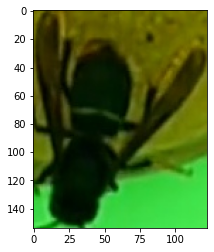

(154, 123, 3)
Random predictions:  tensor([0.7064, 0.2936])
Image predictions:  tensor([0.2689, 0.7311])


In [27]:
files = sorted(glob.glob(os.path.join(image_dir, '*.jpeg')))

for file in files:
    image = io.imread(files[0])
    plt.imshow(image)
    plt.show()
    print('Image shape: ', image.shape)
    
    input_image = torch.tensor(image).permute(2,0,1).unsqueeze(0).float()

output1 = model(torch.rand(1,3,256,256))
output2 = model(image)

print('Random predictions: ', torch.softmax(output1, dim=-1).squeeze().detach())
print('Image predictions: ', torch.softmax(output2, dim=-1).squeeze().detach())


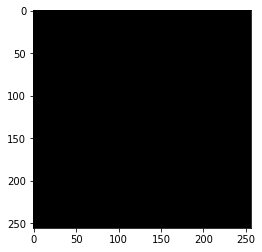

In [23]:
input1 = torch.rand(1,3,256,256)
relevance = model_lrp.relprop(input1)
plt.imshow(relevance.squeeze().permute(1,2,0))

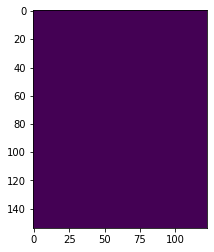

In [24]:
input2 = input_image
relevance = model_lrp.relprop(input2)
plt.imshow(relevance.squeeze().permute(1,2,0)[:,:,0])

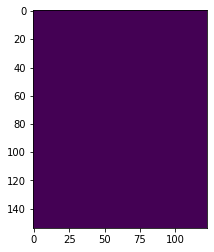

In [25]:
input2 = input_image
relevance = model_lrp.relprop(input2)
plt.imshow(relevance.squeeze().permute(1,2,0)[:,:,1])

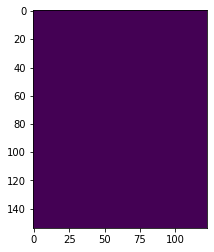

In [26]:
input2 = input_image
relevance = model_lrp.relprop(input2)
plt.imshow(relevance.squeeze().permute(1,2,0)[:,:,2])